In [9]:
#base libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from pprint import pprint 
from time import time
import copy
from pathlib import Path
import datetime

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

#other visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.offline as pyoff
from plotly.offline import init_notebook_mode, iplot

# Pytorch libs
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR, RecurrentNetwork
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [10]:
#start importing data

data = pd.read_csv('../Databases/final_df.csv', dtype={
                                        'ProductFamily_ID': np.int16,
                                         'ProductCategory_ID': np.int16,
                                         'ProductBrand_ID': np.int16,
                                         'ProductName_ID': np.int16,
                                         'ProductPackSKU_ID': np.int16,
                                         'Point-of-Sale_ID': np.int16,
                                         'Value_units': np.int64,
                                         'Value_price': np.float32,
                                         'Unit_Price': np.float32,
                                         'Retail_price': np.float32,
                                         'Is_Promo': np.int16,  
                                         'cluster_value': np.int16,
                                         'cluster_product': np.int16,
                                        })
del data['Unnamed: 0']

data

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value_units,Value_price,Unit_Price,Retail_price,Is_Promo,clusters,Quarter
0,16,11,306,649,1970,1,2017-03-04,2,1540.0,770.0,810.0,0,3,2017Q1
1,16,11,306,649,1970,1,2016-05-02,4,3080.0,770.0,810.0,0,3,2016Q2
2,16,11,306,649,1970,1,2016-10-24,2,1540.0,770.0,810.0,0,3,2016Q4
3,16,11,306,649,1970,1,2017-10-13,2,1620.0,810.0,810.0,0,3,2017Q4
4,16,11,306,649,1970,1,2017-10-14,2,1620.0,810.0,810.0,0,3,2017Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91191593,4,34,279,577,1813,410,2016-01-28,1,643.0,643.0,810.0,1,2,2016Q1
91191594,4,34,279,577,1813,410,2016-04-20,1,638.0,638.0,810.0,1,2,2016Q2
91191595,4,34,279,577,1813,410,2016-04-25,1,652.0,652.0,810.0,1,2,2016Q2
91191596,4,34,279,577,1813,410,2016-04-28,1,643.0,643.0,810.0,1,2,2016Q2


In [3]:
data.describe(include = 'all')

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value_units,Value_price,Unit_Price,Retail_price,Is_Promo,cluster_value,cluster_product
count,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,91191598,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07
unique,NaN,NaN,NaN,NaN,NaN,NaN,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,102159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.040885e+01,1.438313e+02,7.700489e+02,1.460788e+03,4.465983e+03,2.015254e+02,NaN,2.180027e+00,3.517814e+03,1.560057e+03,1.702179e+03,2.630213e-01,1.462153e+00,4.319253e+00
std,6.433262e+00,6.267363e+01,4.706730e+02,8.576705e+02,2.622756e+03,1.217617e+02,NaN,2.291048e+00,6.656522e+03,1.566085e+03,1.910219e+03,4.402739e-01,1.404827e+00,3.660826e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00,-1.000000e+01,-5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.540000e+02,3.590000e+02,7.390000e+02,2.199000e+03,9.200000e+01,NaN,1.000000e+00,8.600000e+02,6.030000e+02,6.680000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.100000e+01,1.780000e+02,7.610000e+02,1.517000e+03,4.628000e+03,2.020000e+02,NaN,1.000000e+00,1.654000e+03,9.450000e+02,1.004500e+03,0.000000e+00,1.000000e+00,5.000000e+00
75%,1.500000e+01,1.780000e+02,1.227000e+03,2.308000e+03,7.095000e+03,3.040000e+02,NaN,2.000000e+00,3.416000e+03,1.829000e+03,1.895000e+03,1.000000e+00,3.000000e+00,8.000000e+00


In [12]:
#convert date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91191598 entries, 0 to 91191597
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ProductFamily_ID    int16         
 1   ProductCategory_ID  int16         
 2   ProductBrand_ID     int16         
 3   ProductName_ID      int16         
 4   ProductPackSKU_ID   int16         
 5   Point-of-Sale_ID    int16         
 6   Date                datetime64[ns]
 7   Value_units         int64         
 8   Value_price         float32       
 9   Unit_Price          float32       
 10  Retail_price        float32       
 11  Is_Promo            int16         
 12  clusters            int64         
 13  Quarter             object        
dtypes: datetime64[ns](1), float32(3), int16(7), int64(2), object(1)
memory usage: 4.9+ GB


In [6]:
print('Min date in DF: %s' % data['Date'].min().date())
print('Max date in DF: %s' % data['Date'].max().date())

Min date in DF: 2016-01-01
Max date in DF: 2019-11-01


Daily data is too sparse, we will start by compressing into weekly data.

In [14]:
#Aggregate by week

grouped_data = data.groupby([pd.Grouper(key='Date', freq='SM'), 'Point-of-Sale_ID', 'ProductName_ID', 'ProductPackSKU_ID']).agg({
                                                                                                                'Value_units': 'sum', 
                                                                                                                }).reset_index().sort_values('Date')

In [16]:
#create cluster dict to map later

prod_dict = data.set_index("Point-of-Sale_ID")["clusters"].to_dict()
val_dict = data.set_index("Point-of-Sale_ID")["clusters"].to_dict()

In [ ]:
del data

#### We already know that there is a difference between the number of SKUs and the number of Product Names: there are more SKUs than Names.

In electronics retail, it is important to remember that, from an SKU standpoint, different products may be considered the same - as in, they are an updated model. We will look into which product_SKU - product-name pairs do not share a 1 to 1 relationship. 

For any given Product name, we should see a multi-modal distribution throughout time - as in different peaks from different SKUs as time evolves.

In [17]:
#check each product's last date

filtered = grouped_data.filter(['Date', 'ProductName_ID', 'Point-of-Sale_ID'])

#get indexes of first record of of a product sale and the last record of a product sale 
first_sales = filtered.sort_values('Date').drop_duplicates(['ProductName_ID'], keep='first').drop('Point-of-Sale_ID', axis = 1)
last_sales = filtered.sort_values('Date').drop_duplicates(['ProductName_ID'], keep='last').drop('Point-of-Sale_ID', axis = 1)

print(f'Indexes and name of first sales: {first_sales}.')
print(f'Indexes and name of last sales: {last_sales}.')

Indexes and name of first sales:                Date  ProductName_ID
0        2015-12-31              21
3        2015-12-31              38
4        2015-12-31              39
5        2015-12-31              55
8        2015-12-31              78
...             ...             ...
26927226 2019-10-15              10
26957247 2019-10-15            2539
26978324 2019-10-15            2541
27013289 2019-10-15             755
27176419 2019-10-31            2666

[2820 rows x 2 columns].
Indexes and name of last sales:                Date  ProductName_ID
78784    2015-12-31             813
102339   2015-12-31             448
236353   2015-12-31            1928
274746   2016-01-15            1106
341789   2016-01-15            2837
...             ...             ...
27271943 2019-10-31            2834
27271944 2019-10-31            2839
27271945 2019-10-31            2845
27271937 2019-10-31            2787
27271947 2019-10-31            2847

[2820 rows x 2 columns].


In [18]:
#Dealing with very recent products

lastdate_treshold = "2018-09-01"
dispensable_prods = list(last_sales[last_sales['Date'] < lastdate_treshold]['ProductName_ID'])

#getting list of products that have not sold
len(dispensable_prods)

476

In [19]:
#Dealing with very recent products

firstdate_treshold = "2019-10-15"
new_prods = list(first_sales[first_sales['Date'] > firstdate_treshold]['ProductName_ID'])

#we have 8 products whose first recorded sale was in the 2 weeks leading up to the end of dataset:
#we will monitor these products very closely
len(new_prods)

1

In [20]:
#removing all observations of dispensable products that will no longer be sold - we are not working so far with product embeddings 
grouped_data = grouped_data.loc[~grouped_data['ProductName_ID'].isin(dispensable_prods)]

In [21]:
new_pivot = pd.pivot_table(grouped_data, index=['Point-of-Sale_ID', 'ProductName_ID'], columns = 'Date', values = 'Value_units',
                    aggfunc='sum').fillna(0)

new_pivot = new_pivot.reset_index()
new_pivot

Date,Point-of-Sale_ID,ProductName_ID,2015-12-31 00:00:00,2016-01-15 00:00:00,2016-01-31 00:00:00,2016-02-15 00:00:00,2016-02-29 00:00:00,2016-03-15 00:00:00,2016-03-31 00:00:00,2016-04-15 00:00:00,...,2019-06-15 00:00:00,2019-06-30 00:00:00,2019-07-15 00:00:00,2019-07-31 00:00:00,2019-08-15 00:00:00,2019-08-31 00:00:00,2019-09-15 00:00:00,2019-09-30 00:00:00,2019-10-15 00:00:00,2019-10-31 00:00:00
0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,10.0,6.0,4.0,4.0,8.0,8.0,2.0,8.0,0.0
4,1,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474997,410,2841,9.0,13.0,6.0,10.0,0.0,3.0,2.0,5.0,...,17.0,6.0,24.0,15.0,9.0,22.0,21.0,17.0,27.0,0.0
474998,410,2845,39.0,55.0,51.0,52.0,49.0,52.0,52.0,41.0,...,21.0,22.0,25.0,37.0,24.0,26.0,27.0,25.0,23.0,11.0
474999,410,2846,1.0,4.0,11.0,21.0,8.0,7.0,22.0,8.0,...,38.0,41.0,25.0,28.0,50.0,33.0,32.0,35.0,62.0,0.0
475000,410,2847,52.0,48.0,60.0,61.0,56.0,46.0,77.0,54.0,...,57.0,56.0,95.0,49.0,48.0,46.0,40.0,59.0,78.0,2.0


In [22]:
melt = new_pivot.melt(id_vars=['Point-of-Sale_ID', 'ProductName_ID'] , var_name='Date', value_name='Value_units')
grouped_data = melt[:]

In [23]:
del melt
del new_pivot

In [24]:
#adding additional columns concerning month, dow, year and week number in the year
grouped_data["month"] = grouped_data.Date.dt.month.astype(str).astype("category")
grouped_data["week_nr"] = grouped_data.Date.dt.isocalendar().week.astype(str).astype("category") # 5 and 6 correspond to Sat and Sun
grouped_data["year"] = grouped_data.Date.dt.year.astype(str).astype("category")

#also creating log of units sold - summing small value to ensure that value never reaches 0
grouped_data["log_units_sold"] = np.log(grouped_data["Value_units"] + 1e-8).astype(np.float64)


#getting other relevant weekly information
#weekly avg sales sales(units)
grouped_data["avg_sales_of_POS"] = grouped_data.groupby(["Date", "Point-of-Sale_ID"]).Value_units.transform("mean")
grouped_data["avg_sales_of_Prod_Name"] = grouped_data.groupby(["Date", "ProductName_ID"]).Value_units.transform("mean")

#converting final variables to categoricals for consistency

grouped_data["ProductName_ID"] = grouped_data["ProductName_ID"].astype(str).astype("category")
grouped_data["Point-of-Sale_ID"] = grouped_data["Point-of-Sale_ID"].astype(str).astype("category")

#check everything again
grouped_data

,Point-of-Sale_ID,ProductName_ID,Date,Value_units,month,week_nr,year,log_units_sold,avg_sales_of_POS,avg_sales_of_Prod_Name
0,1,4,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.000000
1,1,5,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.000000
2,1,6,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.000000
3,1,14,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,4.009756
4,1,15,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.635910
...,...,...,...,...,...,...,...,...,...,...
44175181,410,2841,2019-10-31,0.0,10,44,2019,-18.420681,0.972921,1.412195
44175182,410,2845,2019-10-31,11.0,10,44,2019,2.397895,0.972921,0.924390
44175183,410,2846,2019-10-31,0.0,10,44,2019,-18.420681,0.972921,1.814634
44175184,410,2847,2019-10-31,2.0,10,44,2019,0.693147,0.972921,3.353659


In [25]:
#work on a chunk - data from 2018 and 2019 to expedite training
grouped_data_transformer = grouped_data.loc[(grouped_data["Date"] >= datetime.datetime(2018,10,1))]
grouped_data

,Point-of-Sale_ID,ProductName_ID,Date,Value_units,month,week_nr,year,log_units_sold,avg_sales_of_POS,avg_sales_of_Prod_Name
0,1,4,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.000000
1,1,5,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.000000
2,1,6,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.000000
3,1,14,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,4.009756
4,1,15,2015-12-31,0.0,12,53,2015,-18.420681,5.643180,0.635910
...,...,...,...,...,...,...,...,...,...,...
44175181,410,2841,2019-10-31,0.0,10,44,2019,-18.420681,0.972921,1.412195
44175182,410,2845,2019-10-31,11.0,10,44,2019,2.397895,0.972921,0.924390
44175183,410,2846,2019-10-31,0.0,10,44,2019,-18.420681,0.972921,1.814634
44175184,410,2847,2019-10-31,2.0,10,44,2019,0.693147,0.972921,3.353659


In [26]:
#create series of dates
#create weekly index of dates between start and end-date and index it
date_series = grouped_data["Date"].drop_duplicates().sort_values()
date_series.index = np.arange(1, len(date_series) + 1)

#we now merge dfs on dates
to_merge = date_series.to_frame().reset_index()

#merge on dates
grouped_data = grouped_data.merge(to_merge, how = 'inner')

In [27]:
grouped_data.rename(columns = {'index': "time_idx"}, inplace = True)
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44175186 entries, 0 to 44175185
Data columns (total 11 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Point-of-Sale_ID        category      
 1   ProductName_ID          category      
 2   Date                    datetime64[ns]
 3   Value_units             float64       
 4   month                   category      
 5   week_nr                 category      
 6   year                    category      
 7   log_units_sold          float64       
 8   avg_sales_of_POS        float64       
 9   avg_sales_of_Prod_Name  float64       
 10  time_idx                int64         
dtypes: category(5), datetime64[ns](1), float64(4), int64(1)
memory usage: 2.6 GB


## Modeling stage

We will now design different possible candidate models to perform our time series forecast. For that, we will consider different approaches. We'll use the pytorch forecasting library for this.

1. The predicted sales becomes last know value - benchmarking model.
2. Deep Learning model

As measures of prediction accuracy, we are looking to minimize the difference between prediction and targets:

Accuracy - we can consider the following possibilities as valid metrics to measure model accuracy.

- MAPE (Mean Absolute Percentage Error), 
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)

The implementation of the Pytorch forecasting models is inspired in the Pytorch Forecasting Transformers tutorial with the Stallion dataset:
https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

In [28]:
#Creating Dataset as timeseries Dataset: https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet

# create the dataset from the pandas dataframe
max_prediction_length = 3 #objective is to predict 6 weeks into the future
max_encoder_length = 12 #take previous 12 weeks (roughly 3 months of sales)


context_length = max_encoder_length
prediction_length = max_prediction_length

training_cutoff = grouped_data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    grouped_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Value_units",
    group_ids=["Point-of-Sale_ID", "ProductName_ID"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["Value_units"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, grouped_data, min_prediction_idx=training_cutoff + 1)

In [30]:
# create dataloaders for model - batch training that does not burn a graphics card
batch_size = 256  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers= 2 )
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers= 2)

## Baseline model

Setting up a base model - prediction is last known sale.

In [31]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

2.68477463722229

In [32]:
SMAPE()(baseline_predictions, actuals)

tensor(0.5779)

In [33]:
raw_predictions, x = Baseline().predict(val_dataloader, mode="raw", return_x=True)

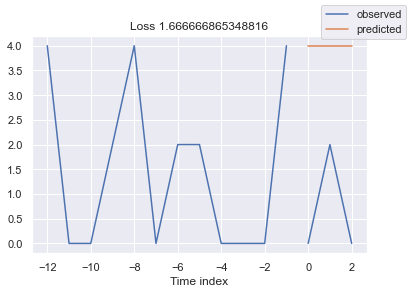

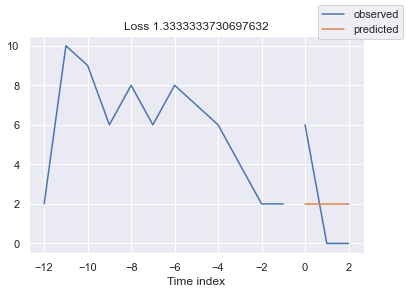

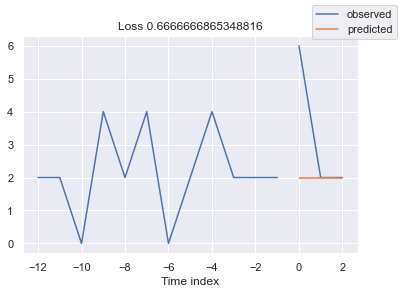

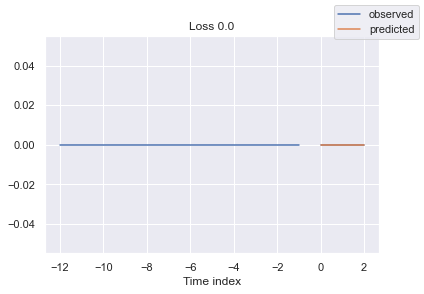

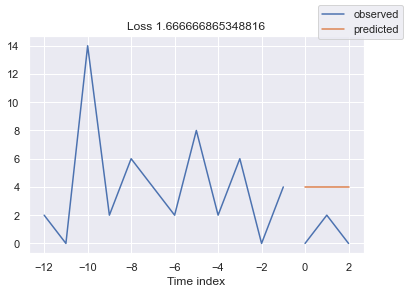

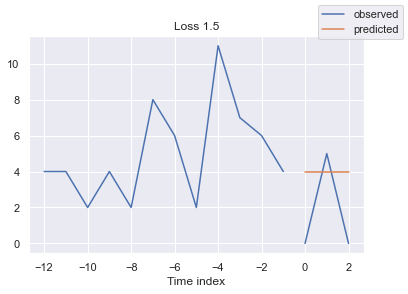

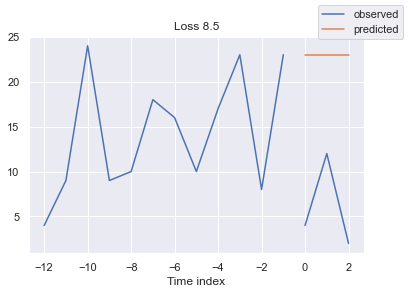

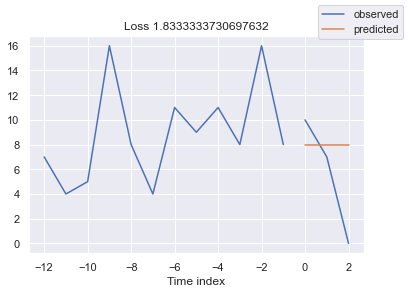

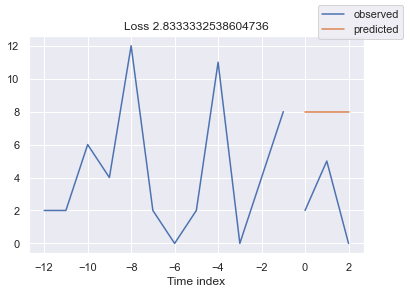

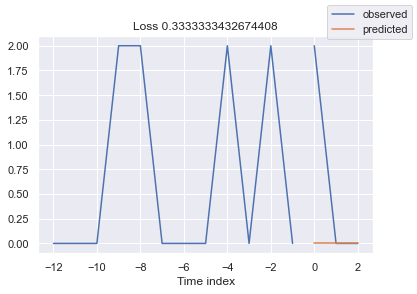

In [34]:
for idx in range(10):  # plot 10 examples
    Baseline().plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### LSTM

In [37]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=2, verbose=True, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [38]:
recn = RecurrentNetwork.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
)

trainer.fit(
    recn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

print(f"Number of parameters in network: {recn.size()/1e3:.1f}k")


  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 1.4 K 
4 | output_projector | Linear         | 11    
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Metric val_loss improved. New best score: 2.538


Metric val_loss improved by 0.035 >= min_delta = 0.0001. New best score: 2.503


Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 2.494


Metric val_loss improved by 0.018 >= min_delta = 0.0001. New best score: 2.475


NameError: name 'tft' is not defined

In [48]:
print(f"Number of parameters in network: {recn.size()/1e3:.1f}k")

Number of parameters in network: 1.4k


In [40]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
recn_predictions = recn.predict(val_dataloader)
(actuals - recn_predictions).abs().mean()

tensor(2.4755)

In [41]:
SMAPE()(recn_predictions, actuals)

tensor(1.6228)

In [42]:
raw_predictions, x = recn.predict(val_dataloader, mode="raw", return_x=True)

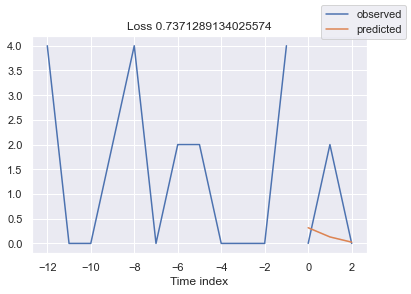

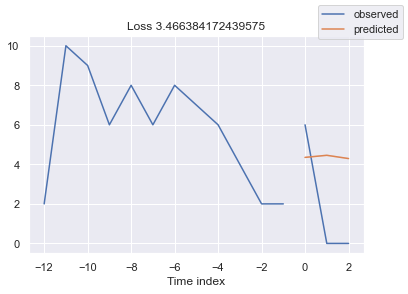

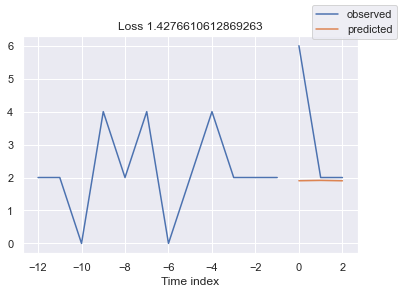

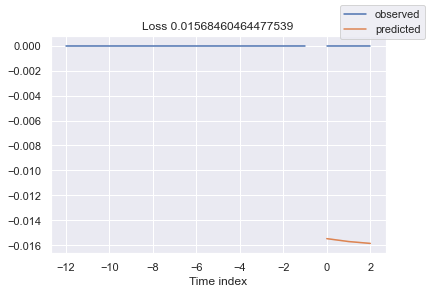

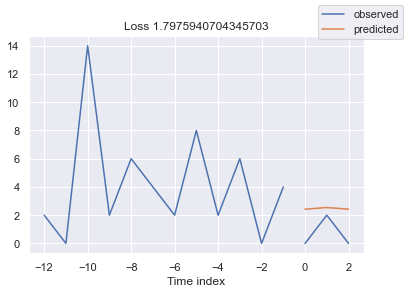

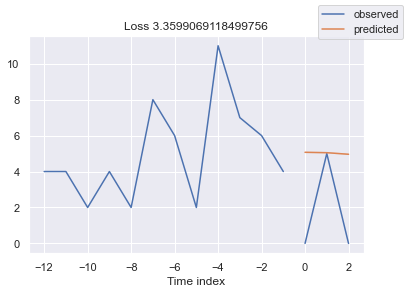

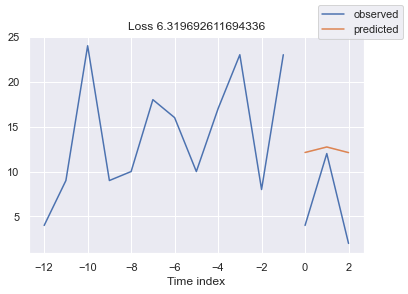

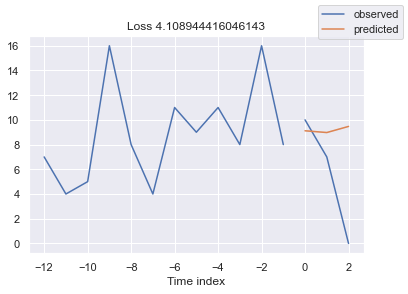

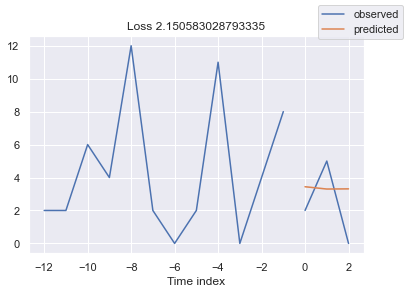

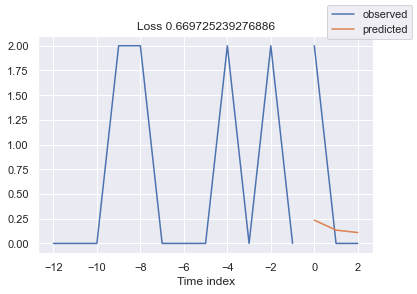

In [43]:
for idx in range(10):  # plot 10 examples
    recn.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

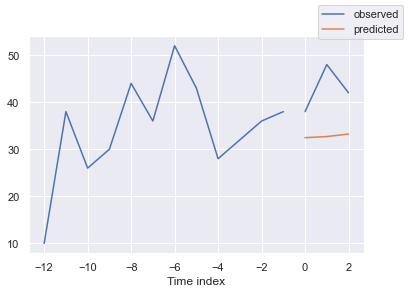

In [82]:
raw_prediction, x = recn.predict(
    training.filter(lambda x: (x['Point-of-Sale_ID'] == '292') & (x.ProductName_ID == '1000')),
    mode="raw",
    return_x=True,
)
recn.plot_prediction(x, raw_prediction, idx=0);

In [83]:
import pickle

LSTM_recn = 'LSTM_recn.sav'
pickle.dump(recn, open(filename, 'wb'))

LSTM_training = 'LSTM_training.sav'
pickle.dump(training, open(filename, 'wb'))